In [2]:
import torch
from functorch import vmap
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import sys
sys.path.append('../')
from typing import Tuple, Any, Callable
import pickle
import scipy.stats as stats
import seaborn as sns


import interflow as itf
import interflow.util as util
import interflow.fabrics as fabrics
import interflow.stochastic_interpolant as stoch_interp
import interflow.gmm as gmm


if torch.cuda.is_available():
    print('CUDA available, setting default tensor residence to GPU.')
    util.set_torch_device('cuda')
    device='cuda'
else:
    print('No CUDA device found!')
    device='cpu'


## from https://stackoverflow.com/questions/56369030/runtimeerror-attempting-to-deserialize-object-on-a-cuda-device
## fix loading when output was on GPU.
import io
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

CUDA available, setting default tensor residence to GPU.


In [3]:
import matplotlib as mpl
from matplotlib import colors

mpl.rcParams['axes.grid']           = True
mpl.rcParams['axes.grid.which']     = 'both'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['axes.facecolor']      = 'white'
mpl.rcParams['grid.color']          = '0.8'
mpl.rcParams['grid.alpha']          = '0.5'
mpl.rcParams['figure.figsize']      = (8, 4)
mpl.rcParams['figure.titlesize']    = 10
mpl.rcParams['font.size']           = 10
mpl.rcParams['legend.fontsize']     = 10
mpl.rcParams['figure.dpi']          = 300
mpl.rcParams['font.family']         = 'serif'
mpl.rcParams['text.usetex']         = True

## Load output data.

In [4]:
# output_folder = '/scratch/nb3397/results/interpolant/gmm_exps/4_19_23'
# output_name   = 'gmm_exp_4_19_23'
# n_exps        = 16


## best high-d run
# output_folder = '/scratch/nb3397/results/interpolant/gmm_exps/4_25_23'
# output_name   = 'run'
# n_exps        = 8


## low-d run
# output_folder = '/scratch/nb3397/results/interpolant/lowd_gmm_exps/4_28_23'
# output_name   = 'run'
# n_exps        = 8


## low-d run round 2
# output_folder = '/scratch/nb3397/results/interpolant/lowd_gmm_exps/5_1_23'
# output_name   = 'run'
# n_exps        = 4


## swap test
# output_folder = '/scratch/nb3397/results/interpolant/lowd_gmm_exps/boundary_test'
# output_name   = 'backward'
# n_exps        = 1


data = {}
for ii in range(n_exps):
    output_str = f'{output_folder}/{output_name}_{ii}.npy'
    
    try:
        curr_dat = pickle.load(open(output_str, 'rb'))
        data[str(ii)] = curr_dat

#     try:
#         if device == 'cpu':
#             curr_dat = CPU_Unpickler(open(output_str, 'rb')).load()
#         else:
#             curr_dat = pickle.load(open(output_str, 'rb'))

    except:
        print(f'Couldnt load experiment {ii}!')

In [5]:
data.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7'])

# Learn b vs. Learn v Comparison.

In [6]:
## identify keys relevant to this visualization
gamma_type      = 'brownian'
path            = 'linear'
online_learning = 1
online_str      = 'online' if online_learning == 1 else 'finite'


keys = []
for key in data.keys():
    if data[key]['config']['gamma_type'] == gamma_type:
        if data[key]['config']['path'] == path:
            if data[key]['config']['online_learning'] == online_learning:
                keys.append(key)


## snag experiment info from the data dictionary
gamma, gamma_dot, gg_dot = fabrics.make_gamma(gamma_type)
hidden_sizes             = data[keys[0]]['config']['hidden_sizes']
ndim                     = data[keys[0]]['config']['ndim']
in_size                  = ndim+1
out_size                 = ndim
inner_act                = data[keys[0]]['config']['inner_act']
final_act                = data[keys[0]]['config']['final_act']
interpolant              = data[keys[0]]['interpolants']['interpolant']
exact_interpolant        = data[keys[0]]['interpolants']['exact']


## construct the neural networks
nets = {}
for key in keys:
    nets[key] = {}
    for param_type in ['bv', 'seta']:
        net = fabrics.make_fc_net(hidden_sizes, in_size, out_size, inner_act, final_act)
        net.load_state_dict(data[key]['params'][f'{param_type}_params'][-1])
        nets[key][param_type] = net

### Compute samples

In [7]:
## sampling settings
eps_vals = [0.0, 1.0, 2.5, 5.0, 10.0]#, 15.0, 25.0]
bs       = int(1e5)
dt       = torch.tensor(5e-3)
x0s      = exact_interpolant.sample_rho0(bs)


## draw samples
with torch.no_grad():
    samples_dict = {}
    for key in keys:
        interpolant = data[key]['interpolants']['interpolant']
        samples_dict[key] = {}

        for eps_val in eps_vals:
            eps_val = torch.tensor(eps_val)
            start_time = time.time()
            print(f'Starting epsilon={eps_val} on key={key}')

            # construct score
            if data[key]['config']['learn_eta']:
                eta = nets[key]['seta']
                s = stoch_interp.SFromEta(eta, gamma)
                t0, tf = torch.tensor(1e-2), torch.tensor(1-1e-2)
            else:
                s = nets[key]['seta']
                t0, tf = torch.tensor(0.0), torch.tensor(1.0)
                
            # construct velocity b
            if data[key]['config']['learn_b']:
                b = nets[key]['bv']
            else:
                v = nets[key]['bv']
                b = stoch_interp.BFromVS(v=v, s=s, gg_dot=gg_dot)


            if eps_val == 0:
                try:
                    integrator = stoch_interp.PFlowIntegrator(
                        b=b, method='dopri5', interpolant=interpolant, n_step=3, sample_only=True
                    )
                    curr_samples = util.grab(
                        integrator.rollout(x0s, t0=t0, tf=tf)[0][-1]
                    )
                except:
                    learn_b   = data[key]['config']['learn_b']
                    learn_eta = data[key]['config']['learn_eta']
                    print(f'Couldnt use dopri5 with learn_b={learn_b}, learn_eta={learn_eta}. Trying adams...')
                    n_step = int((tf - t0) / dt)
                    integrator = stoch_interp.PFlowIntegrator(
                        b=b, method='explicit_adams', interpolant=interpolant, 
                        n_step=n_step, sample_only=True
                    )
                    curr_samples = util.grab(
                        integrator.rollout(x0s, t0=t0, tf=tf)[0][-1]
                    )
            else:
                integrator = stoch_interp.SDEIntegrator(
                    b=b, s=s, dt=dt, eps=eps_val, interpolant=interpolant, n_save=1, n_likelihood=1
                )
                curr_samples = util.grab(
                    integrator.rollout_forward(x0s, t0=t0, tf=tf)[-1]
                )


            samples_dict[key][f'eps={eps_val}'] = curr_samples
            end_time = time.time()
            print(f'Ending epsilon={eps_val} on key={key}. Total time: {end_time - start_time}s.')


print('Finished!')

Starting epsilon=0.0 on key=1
Ending epsilon=0.0 on key=1. Total time: 0.3065311908721924s.
Starting epsilon=1.0 on key=1


/scratch/nb3397/projects/interpolants/stochastic-interpolants/notebooks/../interflow/stochastic_interpolant.py:329: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = t0 + torch.tensor(ii*self.dt).to(x)


Ending epsilon=1.0 on key=1. Total time: 3.3679370880126953s.
Starting epsilon=2.5 on key=1
Ending epsilon=2.5 on key=1. Total time: 3.3675191402435303s.
Starting epsilon=5.0 on key=1
Ending epsilon=5.0 on key=1. Total time: 3.3666536808013916s.
Starting epsilon=10.0 on key=1
Ending epsilon=10.0 on key=1. Total time: 3.366772413253784s.
Starting epsilon=0.0 on key=3
Couldnt use dopri5 with learn_b=0, learn_eta=1. Trying adams...
Ending epsilon=0.0 on key=3. Total time: 1.6216742992401123s.
Starting epsilon=1.0 on key=3
Ending epsilon=1.0 on key=3. Total time: 3.3132028579711914s.
Starting epsilon=2.5 on key=3
Ending epsilon=2.5 on key=3. Total time: 3.312917470932007s.
Starting epsilon=5.0 on key=3
Ending epsilon=5.0 on key=3. Total time: 3.3128247261047363s.
Starting epsilon=10.0 on key=3
Ending epsilon=10.0 on key=3. Total time: 3.3129308223724365s.
Starting epsilon=0.0 on key=5
Ending epsilon=0.0 on key=5. Total time: 0.13234519958496094s.
Starting epsilon=1.0 on key=5
Ending epsilo

### Compute errors

In [8]:
errors = {}
dt     = 5e-2
nts    = int(1.0 / dt + 1)
bs     = int(1e3)
ts     = torch.linspace(0.0, 1.0, nts)


with torch.no_grad():
    for key in keys:
        # save bv, seta errors separately
        errors[key] = {
            'bv_absolute': np.zeros(nts),
            'seta_absolute': np.zeros(nts),
            'bv_relative': np.zeros(nts),
            'seta_relative': np.zeros(nts)
        }

        # grab interpolants
        exact_interp  = data[key]['interpolants']['exact']
        double_p0s    = 0
        double_interp = gmm.GMMInterpolant(
            p0s=exact_interp.p0s.double() / torch.sum(exact_interp.p0s.double()),
            p1s=exact_interp.p1s.double() / torch.sum(exact_interp.p1s.double()),
            mu0s=exact_interp.mu0s.double(),
            mu1s=exact_interp.mu1s.double(),
            C0s=exact_interp.C0s.double(),
            C1s=exact_interp.C1s.double(),
            path=exact_interp.path,
            gamma_type=exact_interp.gamma_type,
            device='cuda',
            use_preconditioner=False
        )
        interp = data[key]['interpolants']['interpolant']

        # grab networks
        seta = nets[key]['seta']
        bv   = nets[key]['bv']

        # compute the l2 error over time
        start_time = time.time()
        print(f"Starting learn_b={data[key]['config']['learn_b']}, learn_eta={data[key]['config']['learn_eta']}.")
        for kk, t in enumerate(ts):
            x0s    = exact_interpolant.sample_rho0(bs)
            x1s    = exact_interpolant.sample_rho1(bs)
            xts    = vmap(lambda x0, x1: interpolant.calc_xt(t, x0, x1)[0], randomness='different')(x0s, x1s)
            tbatch = torch.ones(bs)*t
            txts   = torch.hstack((tbatch[:, None], xts))

            # compute network evaluations
            setas = seta(xts, tbatch)
            bvs   = bv(xts, tbatch)

            # compute exact evaluations
            v_exact = double_interp.v(txts.double())
            s_exact = double_interp.s(txts.double())


            # convert to values of interest
            if data[key]['config']['learn_b']:
                target_bvs = (v_exact - interpolant.gg_dot(tbatch)[:, None]*s_exact).double()
            else:
                target_bvs = v_exact

            if data[key]['config']['learn_eta']:
                target_setas = (-interpolant.gamma(tbatch)[:, None]*s_exact).double()
            else:
                target_setas = s_exact


            # compute this time component of the integral
            errors[key]['bv_absolute'][kk]   = float(torch.mean(torch.sum((target_bvs - bvs)**2, axis=1)))
            errors[key]['bv_relative'][kk]   = errors[key]['bv_absolute'][kk] / float(torch.mean(torch.sum(target_bvs**2, axis=1)))
            errors[key]['seta_absolute'][kk] = float(torch.mean(torch.sum((target_setas - setas)**2, axis=1)))
            errors[key]['seta_relative'][kk] = errors[key]['seta_absolute'][kk] / float(torch.mean(torch.sum(target_setas**2, axis=1)))


            # time and print
            end_time = time.time()
            print(f'Finished t={t}. Time: {end_time-start_time}s')
            start_time = time.time()
        print(f"Finished learn_b={data[key]['config']['learn_b']}, learn_eta={data[key]['config']['learn_eta']}.")
        print()

Starting learn_b=0, learn_eta=0.
Finished t=0.0. Time: 0.5168001651763916s
Finished t=0.05000000074505806. Time: 0.009262561798095703s
Finished t=0.10000000149011612. Time: 0.008620738983154297s
Finished t=0.15000000596046448. Time: 0.008570194244384766s
Finished t=0.20000000298023224. Time: 0.008583307266235352s
Finished t=0.25. Time: 0.0085601806640625s
Finished t=0.30000001192092896. Time: 0.008539676666259766s
Finished t=0.3499999940395355. Time: 0.008550643920898438s
Finished t=0.4000000059604645. Time: 0.00852203369140625s
Finished t=0.45000001788139343. Time: 0.008554220199584961s
Finished t=0.5. Time: 0.008577108383178711s
Finished t=0.550000011920929. Time: 0.008575201034545898s
Finished t=0.6000000238418579. Time: 0.008540153503417969s
Finished t=0.6499999761581421. Time: 0.008552074432373047s
Finished t=0.699999988079071. Time: 0.008506059646606445s
Finished t=0.75. Time: 0.010767459869384766s
Finished t=0.800000011920929. Time: 0.00854635238647461s
Finished t=0.850000023841

/state/partition1/job-32969241/ipykernel_2848595/2929028294.py:74: RuntimeWarning: divide by zero encountered in scalar divide
  errors[key]['seta_relative'][kk] = errors[key]['seta_absolute'][kk] / float(torch.mean(torch.sum(target_setas**2, axis=1)))


Finished t=0.15000000596046448. Time: 0.011286258697509766s
Finished t=0.20000000298023224. Time: 0.008638143539428711s
Finished t=0.25. Time: 0.008785486221313477s
Finished t=0.30000001192092896. Time: 0.00860905647277832s
Finished t=0.3499999940395355. Time: 0.008593082427978516s
Finished t=0.4000000059604645. Time: 0.008630514144897461s
Finished t=0.45000001788139343. Time: 0.008672952651977539s
Finished t=0.5. Time: 0.008602142333984375s
Finished t=0.550000011920929. Time: 0.00860738754272461s
Finished t=0.6000000238418579. Time: 0.008644819259643555s
Finished t=0.6499999761581421. Time: 0.008600711822509766s
Finished t=0.699999988079071. Time: 0.008610963821411133s
Finished t=0.75. Time: 0.008614301681518555s
Finished t=0.800000011920929. Time: 0.008614540100097656s
Finished t=0.8500000238418579. Time: 0.008618593215942383s
Finished t=0.8999999761581421. Time: 0.00863027572631836s
Finished t=0.949999988079071. Time: 0.008625984191894531s
Finished t=1.0. Time: 0.008629322052001953s

s loss: 4.928348395827831. b loss: 0.9263763788804186


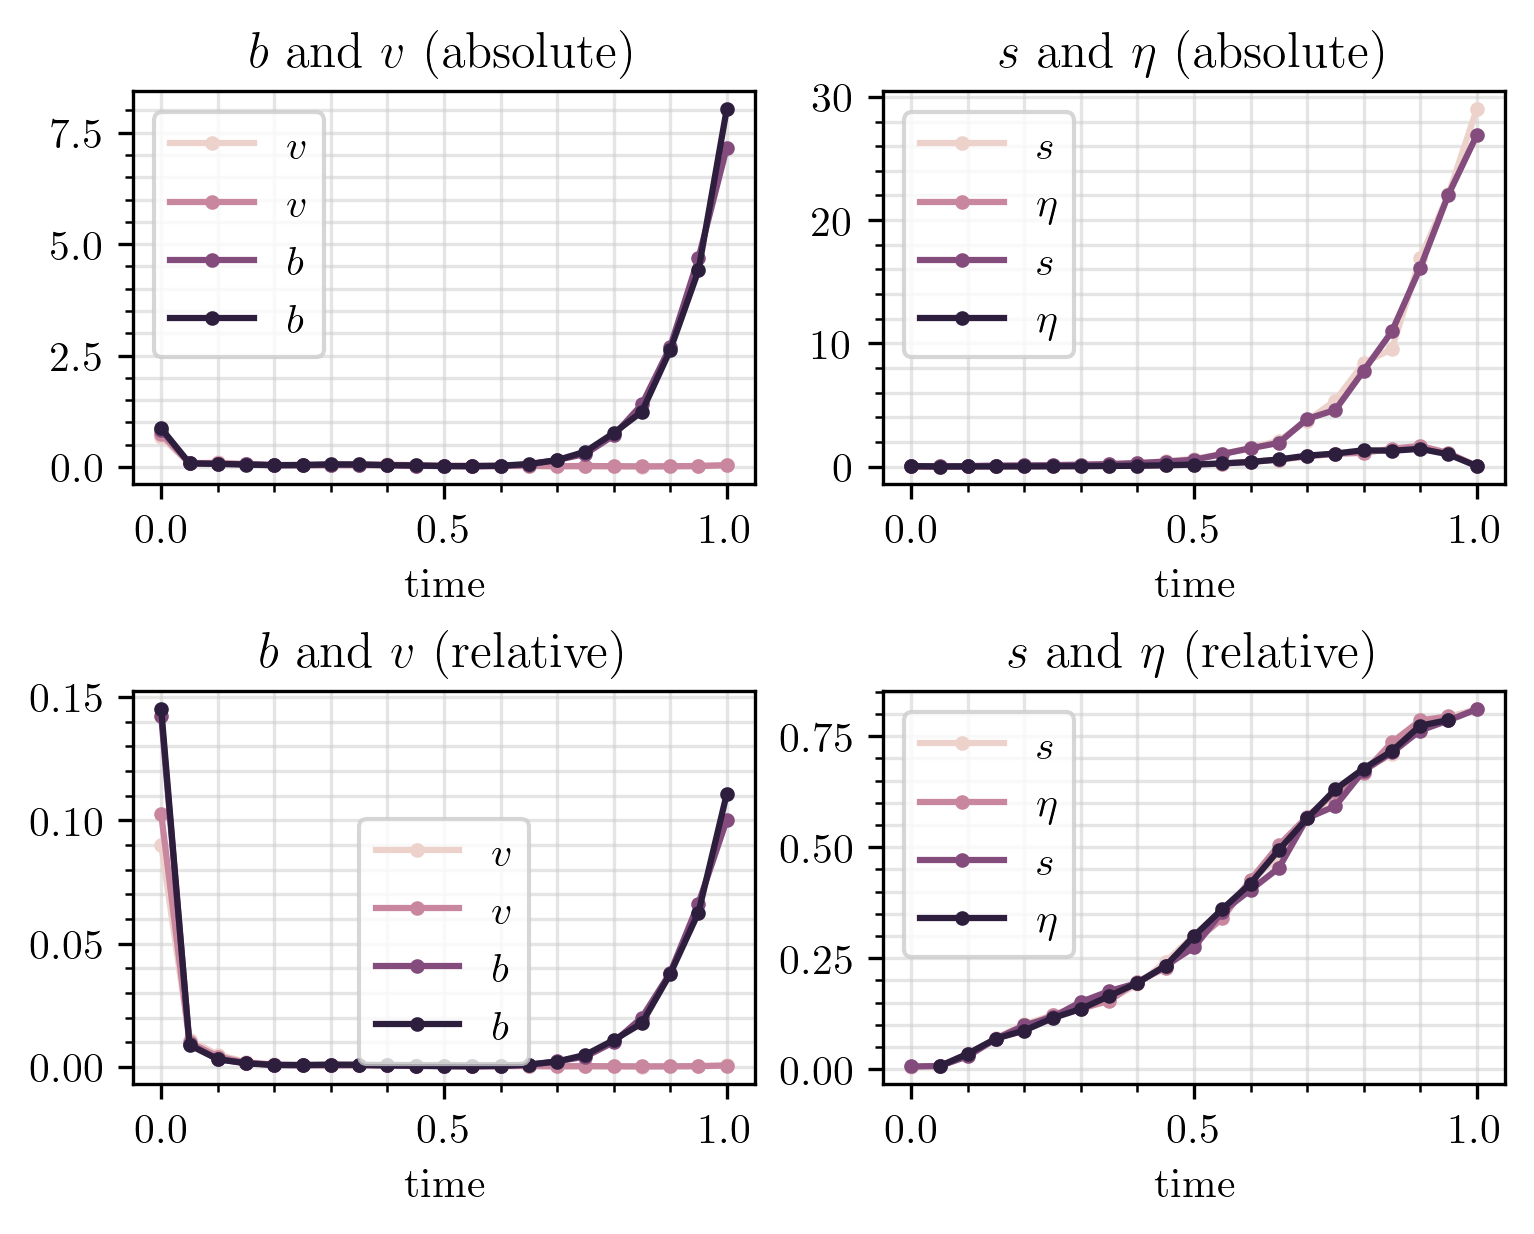

In [9]:
plt.close('all')
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 4), constrained_layout=True, sharex=False)
cmap = sns.cubehelix_palette(n_colors=4)


for kk, key in enumerate(keys):
    for ii in range(nrows):
        if ii == 0:
            key_str = 'absolute'
            title_str = '(absolute)'
        else:
            key_str = 'relative'
            title_str = '(relative)'
            
        axs[ii, 0].set_title(fr"$b$ and $v$ {title_str}")
        bv_label = r"$b$" if data[key]['config']['learn_b'] else r"$v$"
        axs[ii, 0].plot(ts.cpu().numpy(), errors[key][f'bv_{key_str}'], 
                        label=bv_label, alpha=1.0, color=cmap[kk], marker='o', ms=2.5)
        axs[ii, 0].legend()
        axs[ii, 0].set_xlabel('time')
        

        axs[ii, 1].set_title(fr"$s$ and $\eta$ {title_str}")
        seta_label = r"$\eta$" if data[key]['config']['learn_eta'] else r"$s$"
        axs[ii, 1].plot(ts.cpu().numpy(), errors[key][f'seta_{key_str}'], 
                        label=seta_label, alpha=1.0, color=cmap[kk], marker='o', ms=2.5)
        axs[ii, 1].legend()
        axs[ii, 1].set_xlabel('time')
        

    if data[key]['config']['learn_b'] and not data[key]['config']['learn_eta']:
        s_loss = np.sum(errors[key]['seta_absolute']*dt)
        b_loss = np.sum(errors[key]['bv_absolute']*dt)
        print(f's loss: {s_loss}. b loss: {b_loss}')

### Visualize samples.

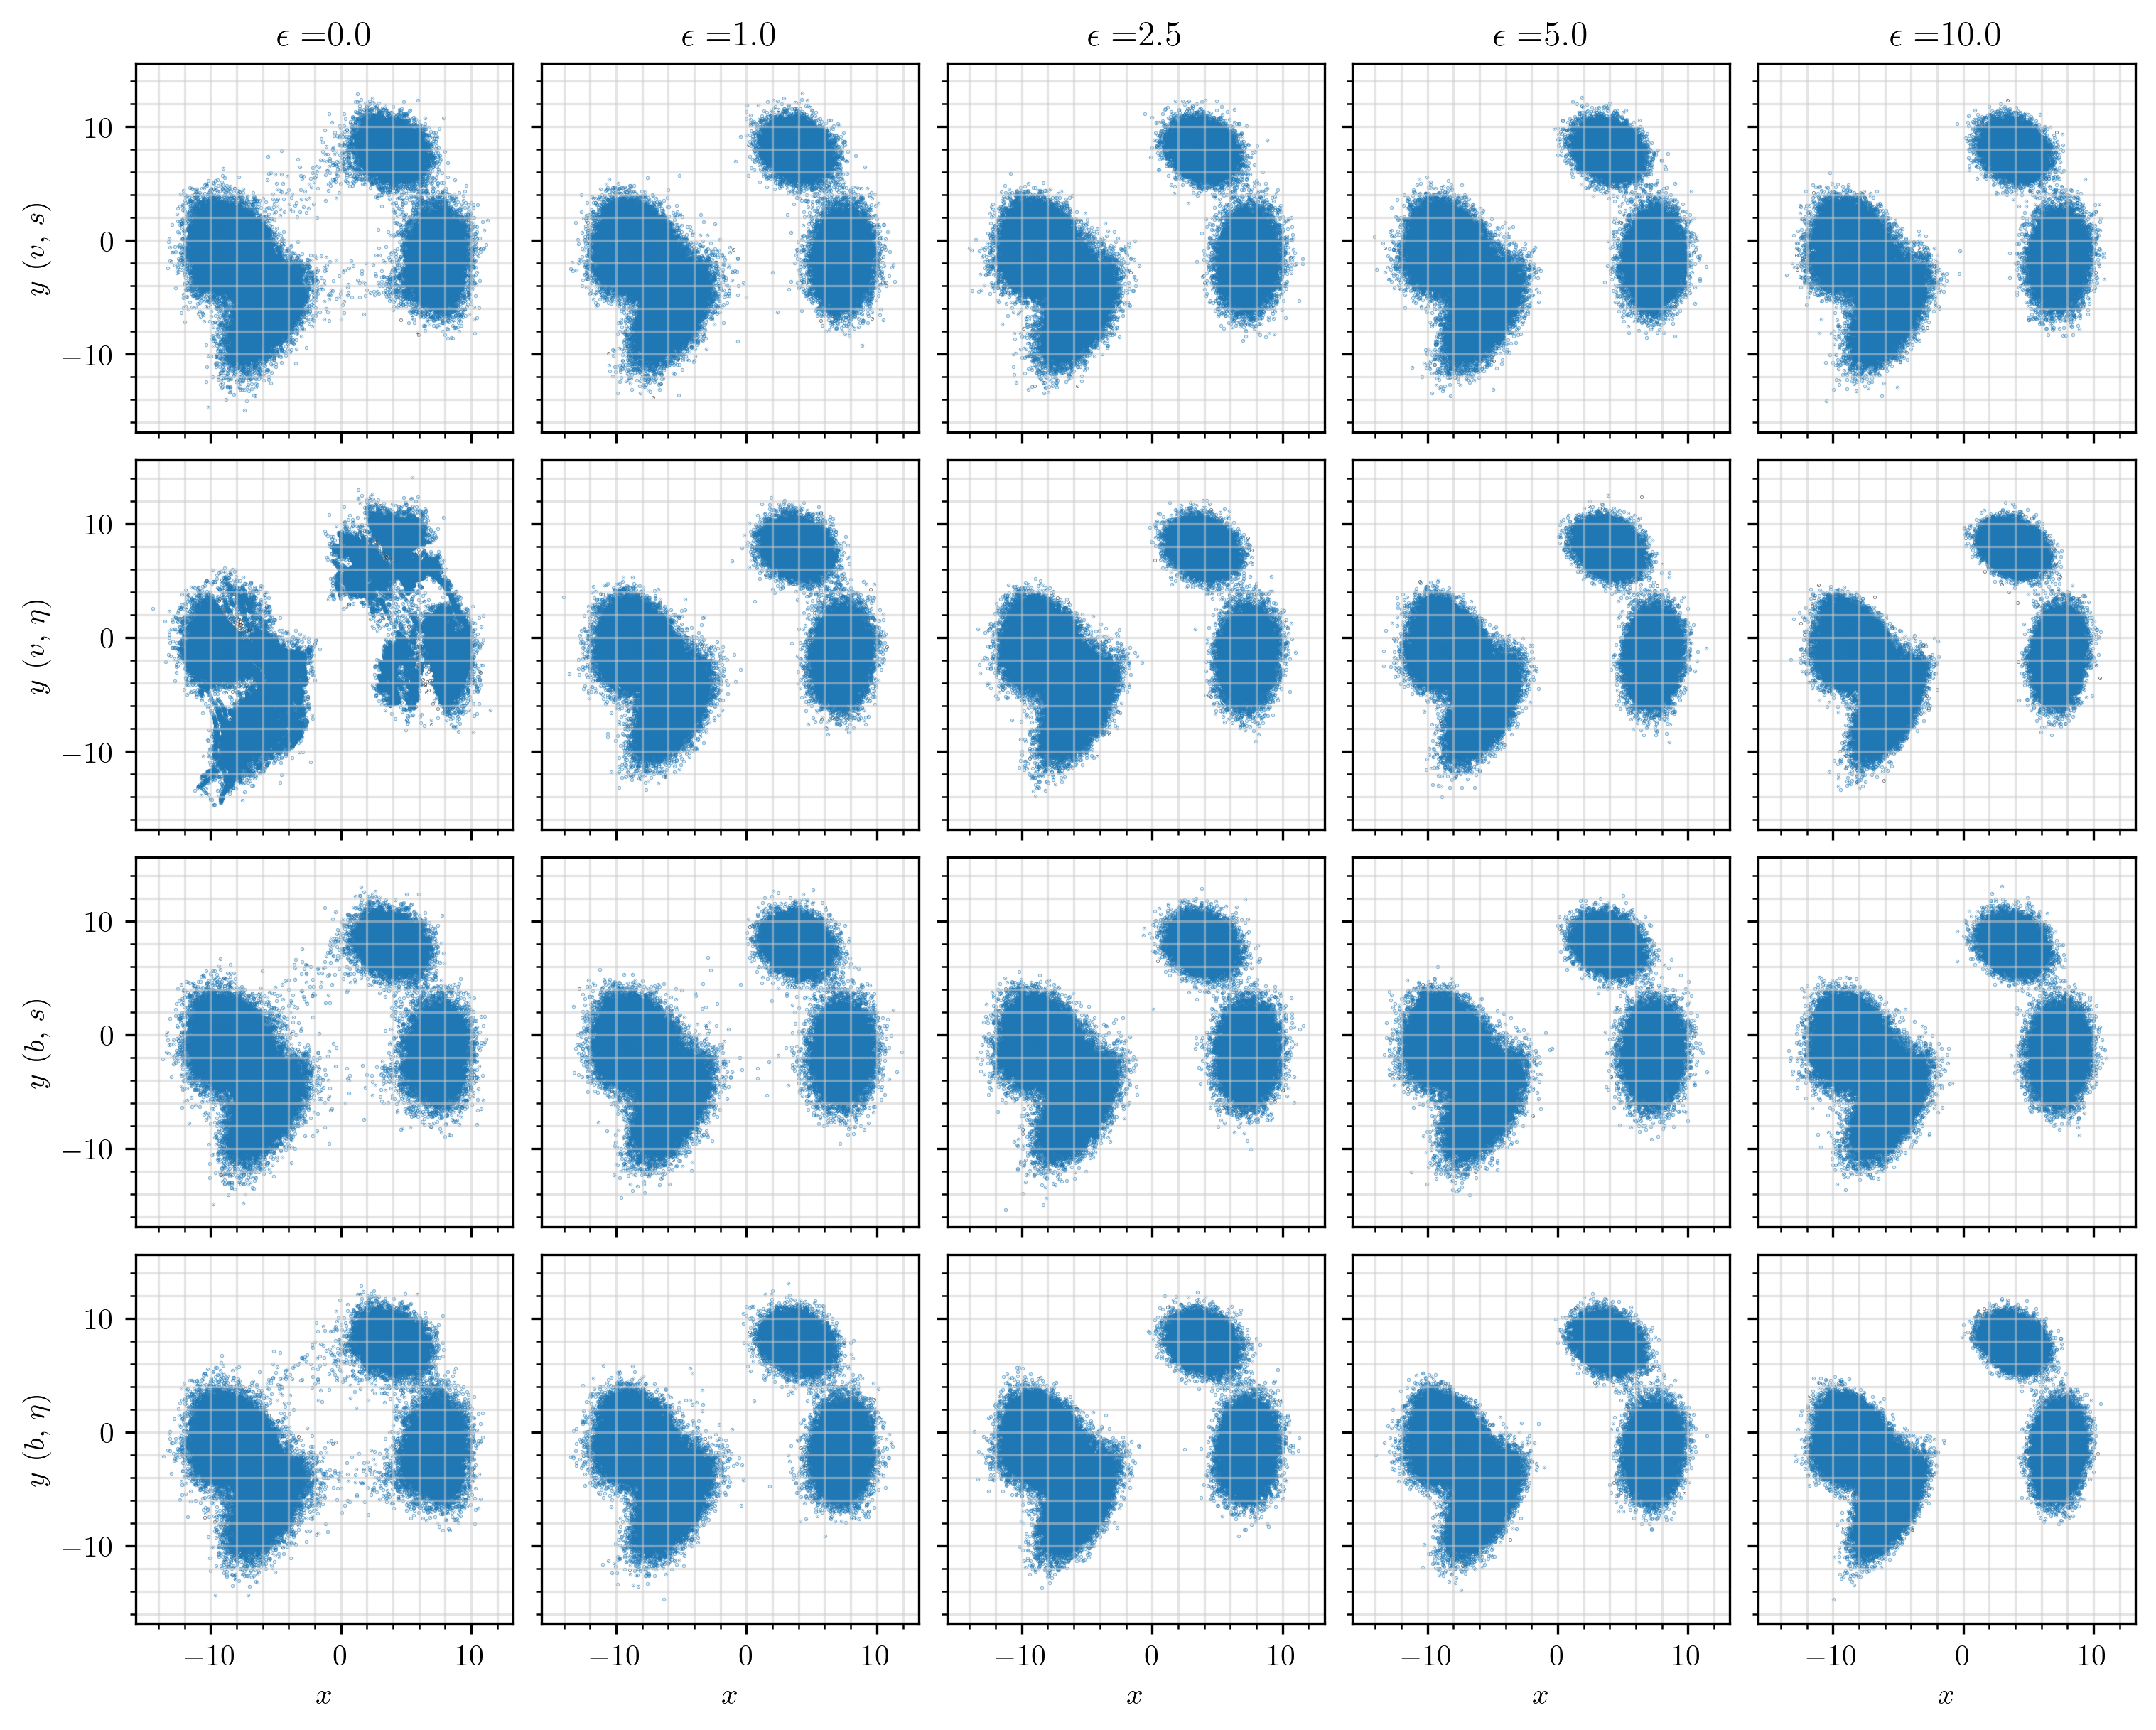

In [13]:
## plot samples
nrows = len(keys)
ncols = len(eps_vals)
fig, axs = plt.subplots(figsize=(2*ncols, 2*nrows), nrows=nrows, ncols=ncols, sharex=True, sharey=True, constrained_layout=True)


for ii, key in enumerate(keys):
    for jj, eps_val in enumerate(eps_vals):
        ax = axs[ii, jj]
        eps_key = f'eps={eps_val}'
        curr_samples = samples_dict[key][eps_key]


        x1s = util.grab(exact_interpolant.sample_rho1(bs))
        ax.scatter(x1s[:, 0], x1s[:, 1], s=0.05, color='k', alpha=0.5)
        ax.scatter(curr_samples[:, 0], curr_samples[:, 1], s=0.1, alpha=0.5)


        if jj == 0:
            bv_str   = r"$b$" if data[key]['config']['learn_b'] else r"$v$"
            seta_str = r"$\eta$" if data[key]['config']['learn_eta'] else r"$s$"
            ax.set_ylabel(fr"$y$ ({bv_str}, {seta_str})")


        if ii == 0:
            ax.set_title(rf"$\epsilon=${eps_val}")


        if ii == nrows-1:
            ax.set_xlabel(r"$x$")


# fig.savefig('/scratch/nb3397/results/interpolant/gmm_exps/4_25_23/figs/online/samples.pdf', 
#             transparent=True, bbox_inches='tight', dpi=300, rasterize=True)

### Compute KDEs

In [14]:
kde_rslts = {}
nbins     = 100


targets = util.grab(exact_interpolant.sample_rho1(bs))
xs, ys = targets[:, 0], targets[:, 1]
x_grid, y_grid = np.mgrid[xs.min():xs.max():nbins*1j, ys.min():ys.max():nbins*1j]
kernel_model = stats.gaussian_kde([xs, ys], bw_method='scott')
kde_rslts['exact'] = kernel_model(np.vstack([x_grid.flatten(), y_grid.flatten()]))


with torch.no_grad():
    for ii, key in enumerate(keys):
        kde_rslts[key] = {}
        for jj, eps_val in enumerate(eps_vals):
            start_time = time.time()
            print(f'Starting key={key} for epsilon={eps_val}.')
            curr_samps = samples_dict[key][f'eps={eps_val}']
            xs, ys = curr_samps[:, 0], curr_samps[:, 1]
            kernel_model = stats.gaussian_kde([xs, ys], bw_method='scott')
            kde_rslts[key][f'eps={eps_val}'] = kernel_model(np.vstack([x_grid.flatten(), y_grid.flatten()]))

Starting key=1 for epsilon=0.0.
Starting key=1 for epsilon=1.0.
Starting key=1 for epsilon=2.5.
Starting key=1 for epsilon=5.0.
Starting key=1 for epsilon=10.0.
Starting key=3 for epsilon=0.0.
Starting key=3 for epsilon=1.0.
Starting key=3 for epsilon=2.5.
Starting key=3 for epsilon=5.0.
Starting key=3 for epsilon=10.0.
Starting key=5 for epsilon=0.0.
Starting key=5 for epsilon=1.0.
Starting key=5 for epsilon=2.5.
Starting key=5 for epsilon=5.0.
Starting key=5 for epsilon=10.0.
Starting key=7 for epsilon=0.0.
Starting key=7 for epsilon=1.0.
Starting key=7 for epsilon=2.5.
Starting key=7 for epsilon=5.0.
Starting key=7 for epsilon=10.0.


### Visualize KDEs

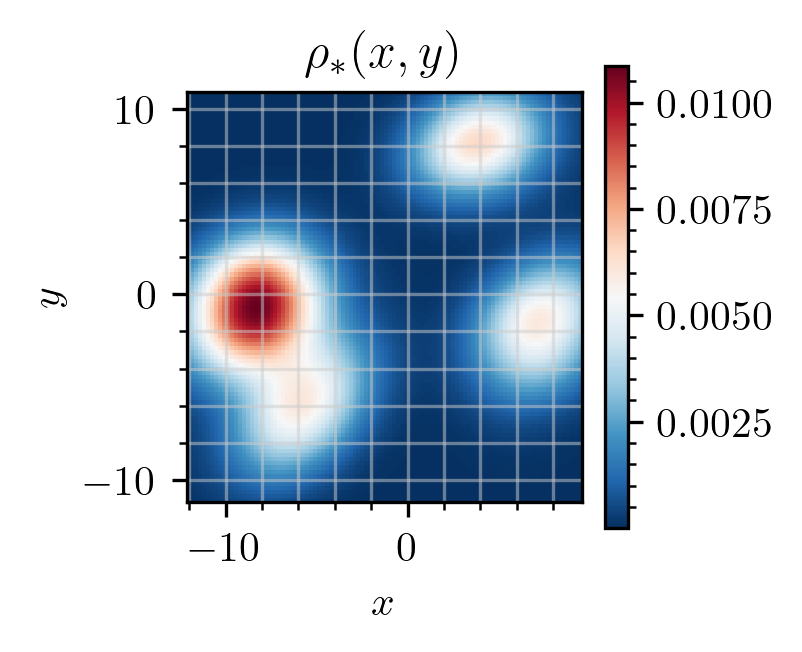

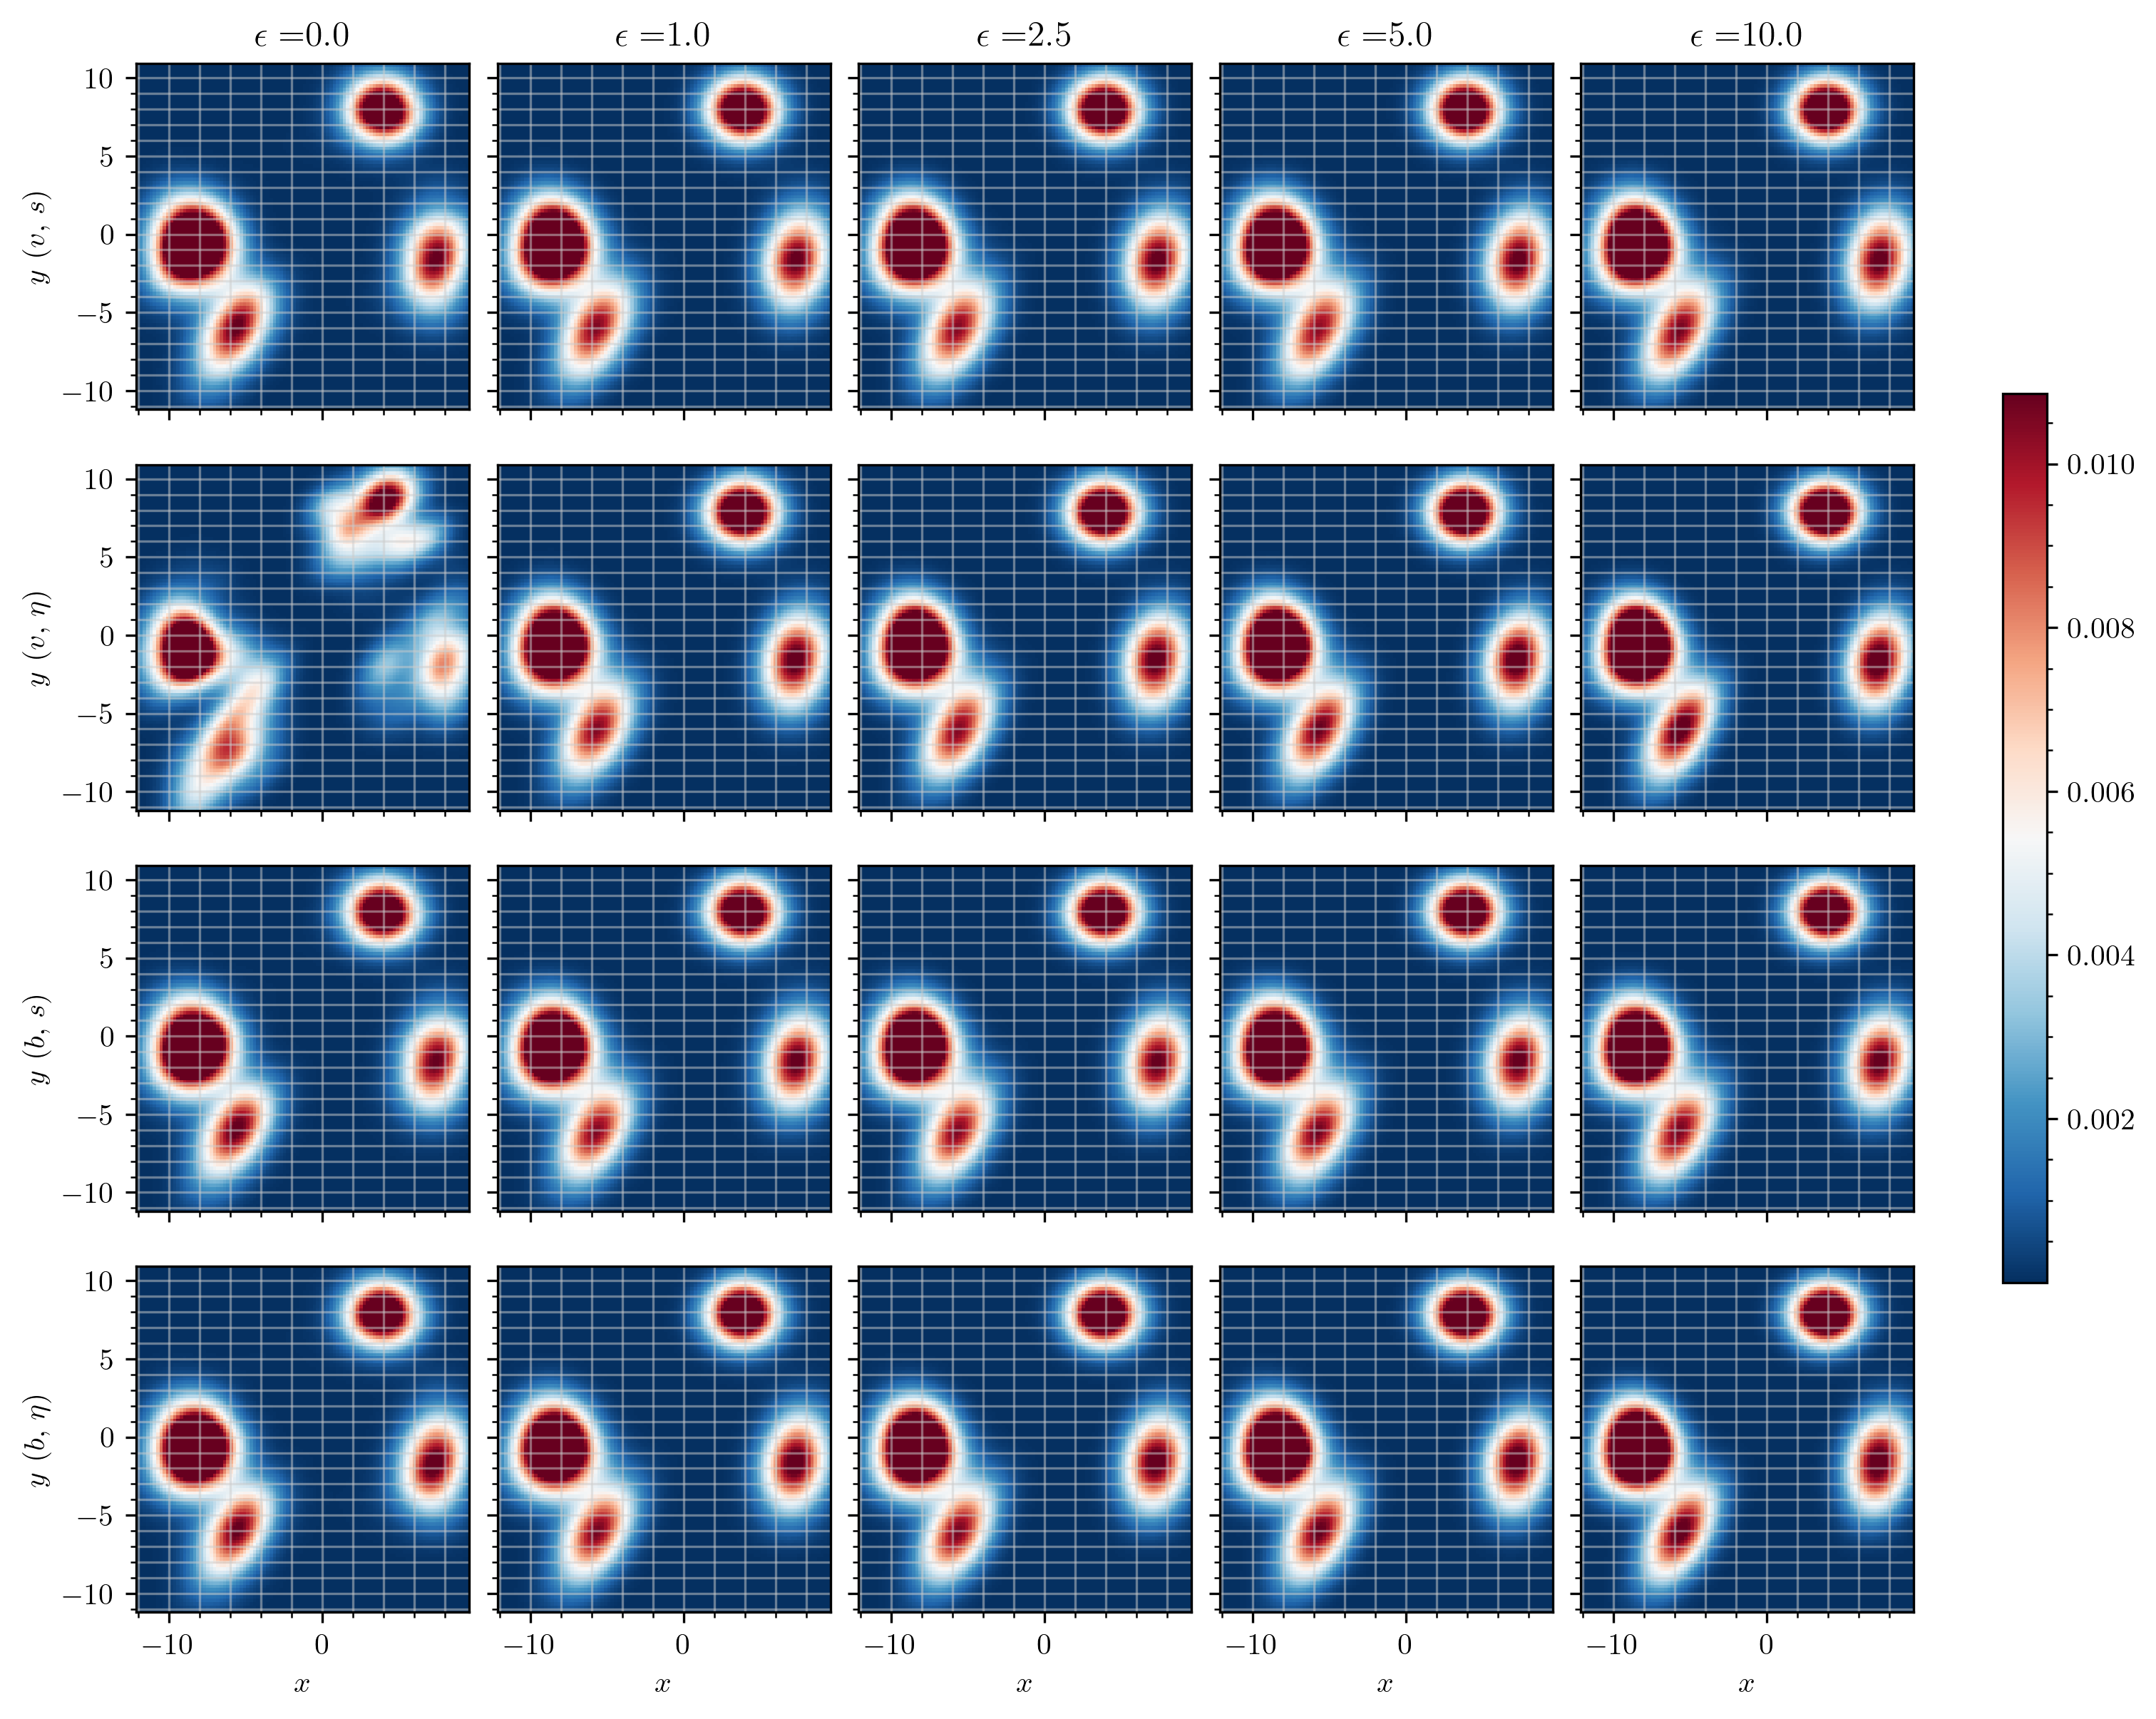

In [15]:
## plot samples
plt.close('all')


xmin, xmax, ymin, ymax = x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()
fig, ax = plt.subplots(figsize=(2, 2))
vmin = kde_rslts['exact'].min()
vmax = kde_rslts['exact'].max()
cmap = plt.cm.RdBu_r
exact_mesh = ax.pcolormesh(x_grid, y_grid, kde_rslts['exact'].reshape(x_grid.shape), shading='auto', 
                           rasterized=True, cmap=cmap, vmin = vmin, vmax=vmax)

cbar = fig.colorbar(exact_mesh, ax=ax, norm=colors.Normalize(vmin=vmin, vmax=vmax), fraction=0.1)
ax.set_aspect((ymax-ymin) / (xmax-xmin))
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_title(r"$\rho_*(x, y)$")
# fig.savefig('/scratch/nb3397/results/interpolant/gmm_exps/4_25_23/figs/online/target.pdf', transparent=True, bbox_inches='tight', dpi=300)


nrows = len(keys)
ncols = len(eps_vals)
fig, axs = plt.subplots(figsize=(2*ncols, 2*nrows), nrows=nrows, ncols=ncols, sharex=True, sharey=True, constrained_layout=True)
for ii, key in enumerate(keys):
    for jj, eps_val in enumerate(eps_vals):
        ax = axs[ii, jj]
        eps_key = f'eps={eps_val}'
        kde_vals = kde_rslts[key][eps_key]
        mesh = ax.pcolormesh(
            x_grid, y_grid, kde_vals.reshape(x_grid.shape), shading='auto', rasterized=True, cmap=cmap, vmin=vmin, vmax=vmax
        )
        ax.set_aspect((ymax-ymin) / (xmax-xmin))


        if jj == 0:
            bv_str   = r"$b$" if data[key]['config']['learn_b'] else r"$v$"
            seta_str = r"$\eta$" if data[key]['config']['learn_eta'] else r"$s$"
            ax.set_ylabel(fr"$y$ ({bv_str}, {seta_str})")


        if ii == 0:
            ax.set_title(rf"$\epsilon=${eps_val}")


        if ii == nrows-1:
            ax.set_xlabel(r"$x$")


norm = colors.Normalize(vmin=vmin, vmax=vmax)
cbar = fig.colorbar(exact_mesh, ax=axs.ravel(), norm=norm, fraction=0.025)
# fig.savefig('/scratch/nb3397/results/interpolant/gmm_exps/4_25_23/figs/online/gmm_densities.pdf', transparent=True, bbox_inches='tight', dpi=300)

### Visualize KDE discrepancies.

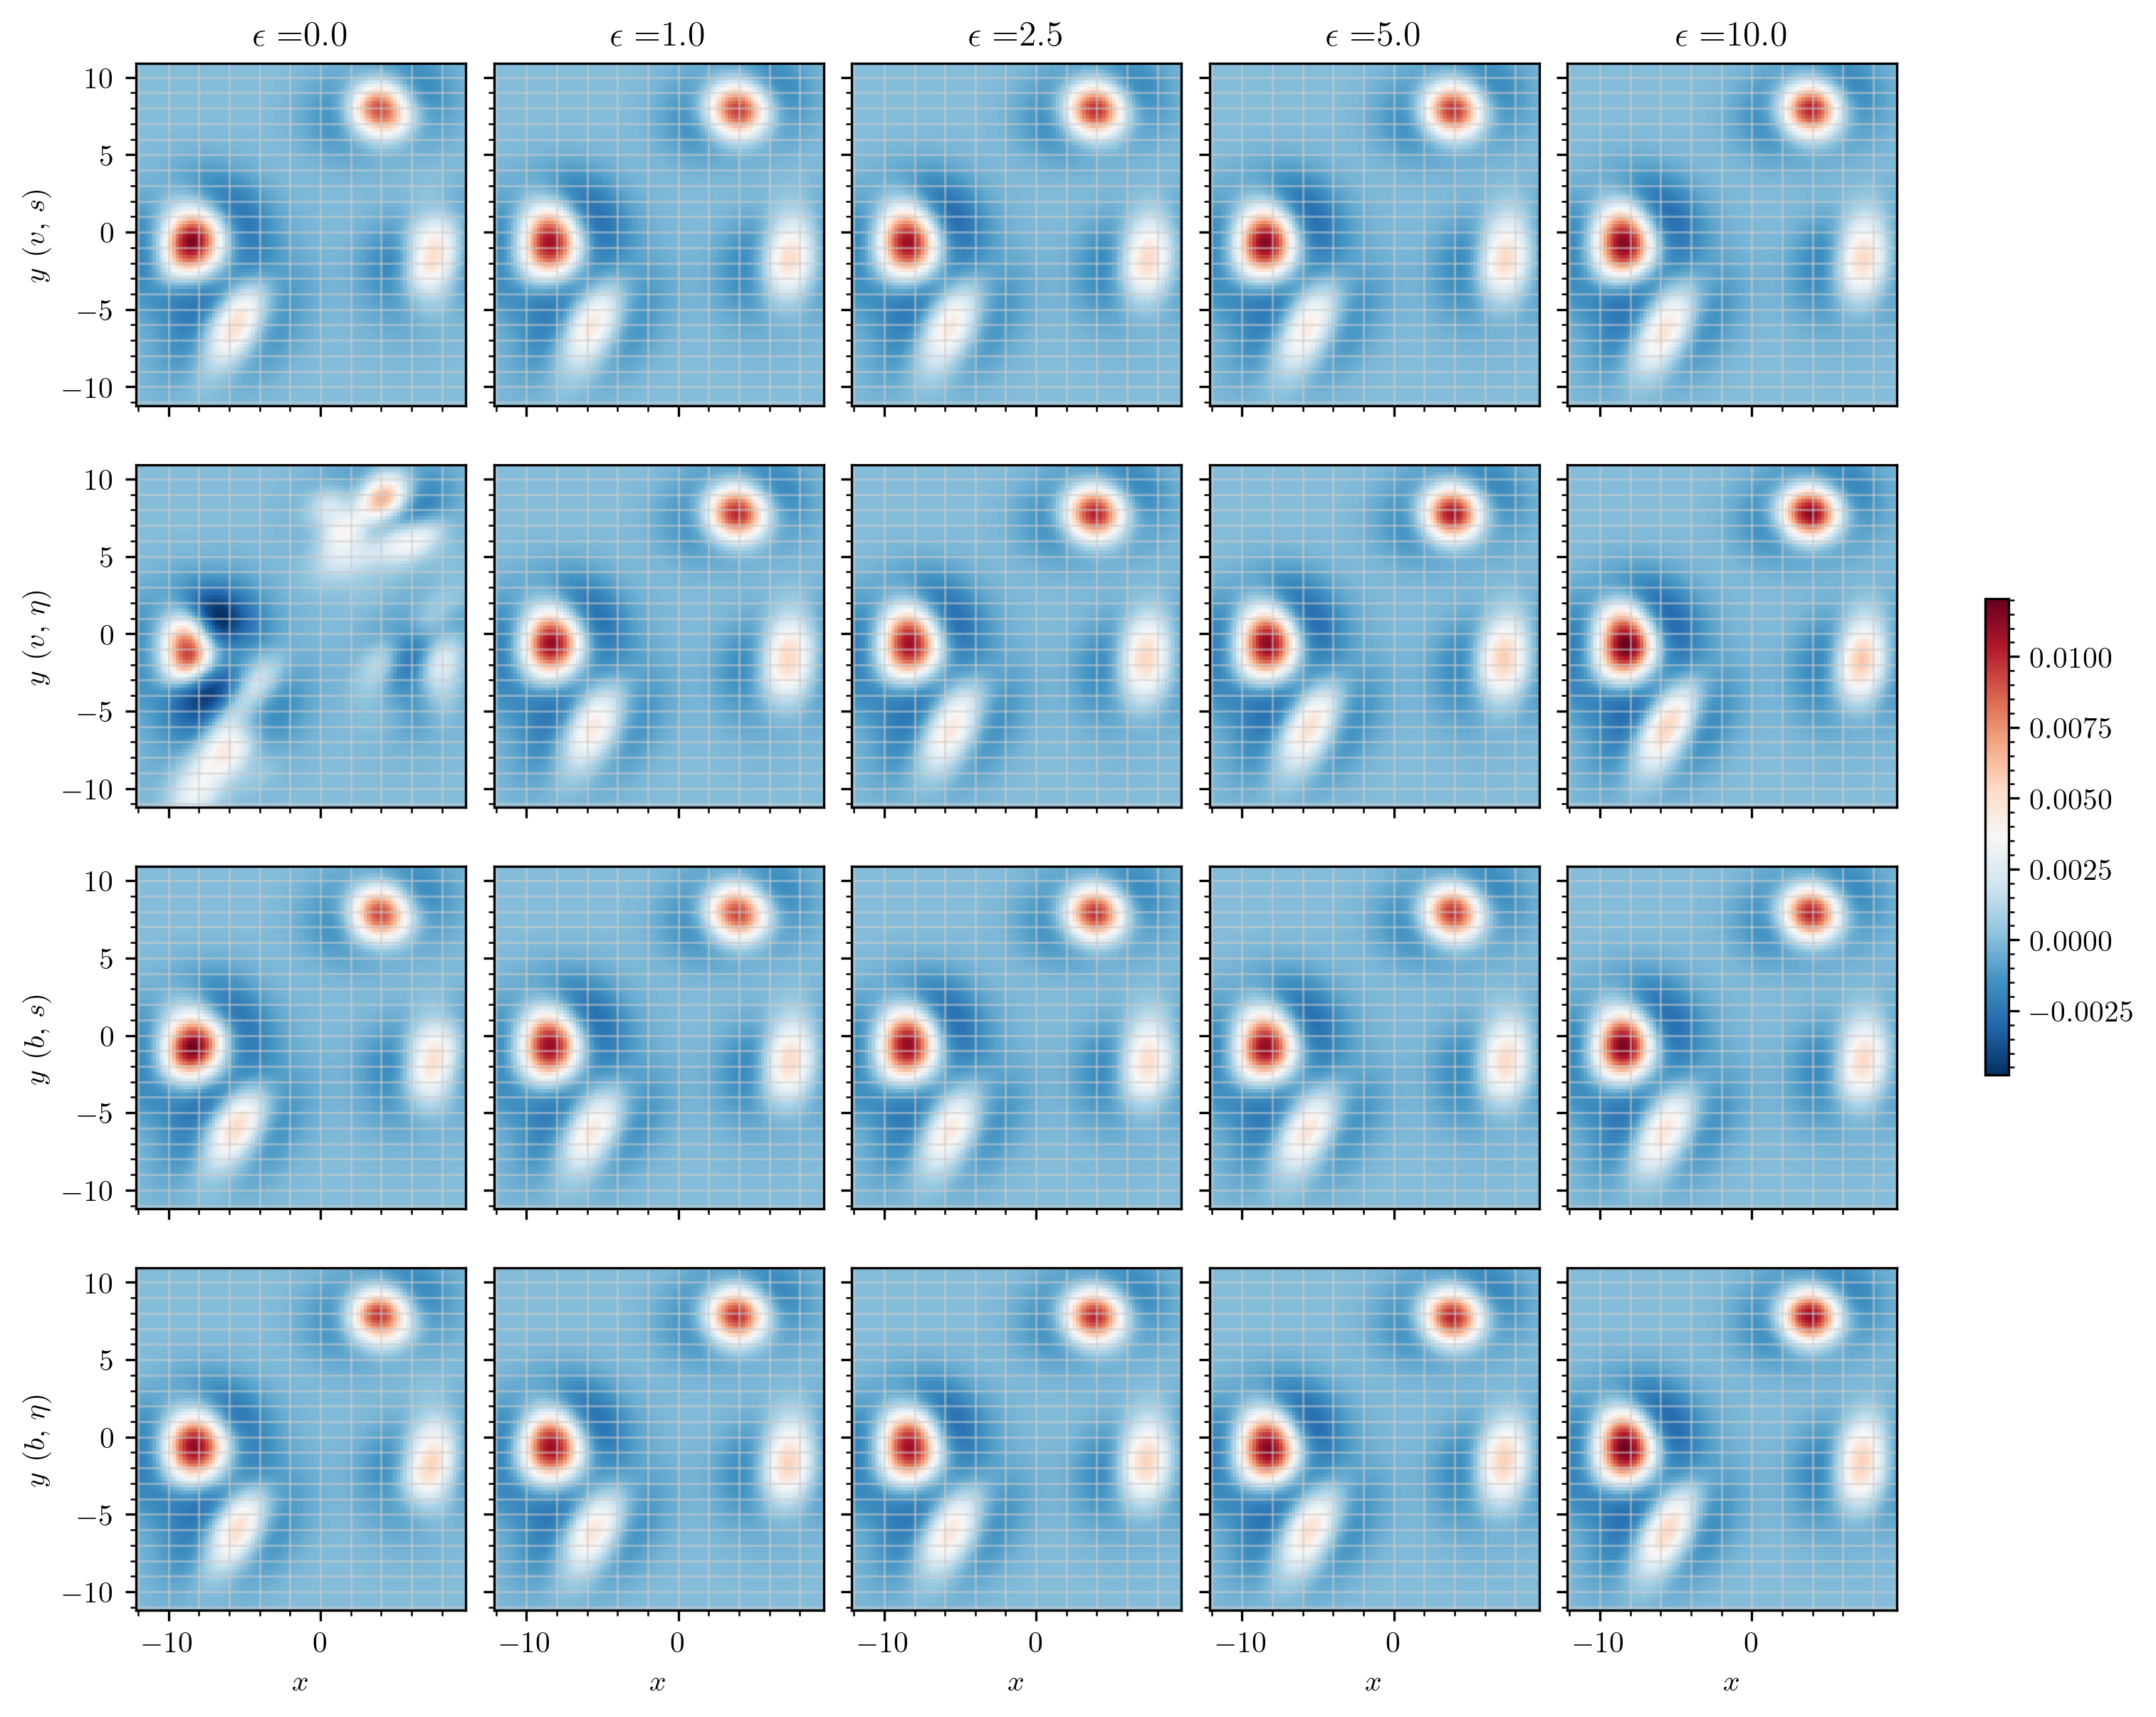

In [16]:
## plot samples
plt.close('all')
xmin, xmax, ymin, ymax = x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()

vmin = np.inf
vmax = -np.inf
for ii, key in enumerate(keys):
    for jj, eps_val in enumerate(eps_vals):
        eps_key = f'eps={eps_val}'
        curr_diff = kde_rslts[key][eps_key] - kde_rslts['exact']
        vmin = min(vmin, curr_diff.min())
        vmax = max(vmax, curr_diff.max())


nrows = len(keys)
ncols = len(eps_vals)
fig, axs = plt.subplots(figsize=(2*ncols, 2*nrows), nrows=nrows, ncols=ncols, sharex=True, sharey=True, constrained_layout=True)
for ii, key in enumerate(keys):
    for jj, eps_val in enumerate(eps_vals):
        ax = axs[ii, jj]
        eps_key = f'eps={eps_val}'
        diff_vals = kde_rslts[key][eps_key] - kde_rslts['exact']
        mesh = ax.pcolormesh(x_grid, y_grid, diff_vals.reshape(x_grid.shape), shading='auto', rasterized=True, cmap=plt.cm.RdBu_r, vmin=vmin, vmax=vmax)
        ax.set_aspect((ymax-ymin) / (xmax-xmin))


        if jj == 0:
            bv_str   = r"$b$" if data[key]['config']['learn_b'] else r"$v$"
            seta_str = r"$\eta$" if data[key]['config']['learn_eta'] else r"$s$"
            ax.set_ylabel(fr"$y$ ({bv_str}, {seta_str})")


        if ii == 0:
            ax.set_title(rf"$\epsilon=${eps_val}")


        if ii == nrows-1:
            ax.set_xlabel(r"$x$")


cbar = fig.colorbar(mesh, ax=axs.ravel(), norm=colors.Normalize(vmin=vmin, vmax=vmax), shrink=0.3)
# fig.savefig('/scratch/nb3397/results/interpolant/gmm_exps/4_25_23/figs/online/gmm_density_errors.pdf', transparent=True, bbox_inches='tight', dpi=300)

### Compute KL divergences.

In [17]:
dx, dy = np.diff(x_grid[:, 0])[0], np.diff(y_grid[0, :])[0]
kls = {}

for ii, key in enumerate(keys):
    kls[key] = np.zeros(len(eps_vals))
    for jj, eps_val in enumerate(eps_vals):
        eps_key = f'eps={eps_val}'
        kls[key][jj] = dx*dy*np.sum(
            (np.log(kde_rslts['exact']) - np.log(kde_rslts[key][eps_key]))*kde_rslts['exact']
        )

0.9263763788804186 4.928348395827831


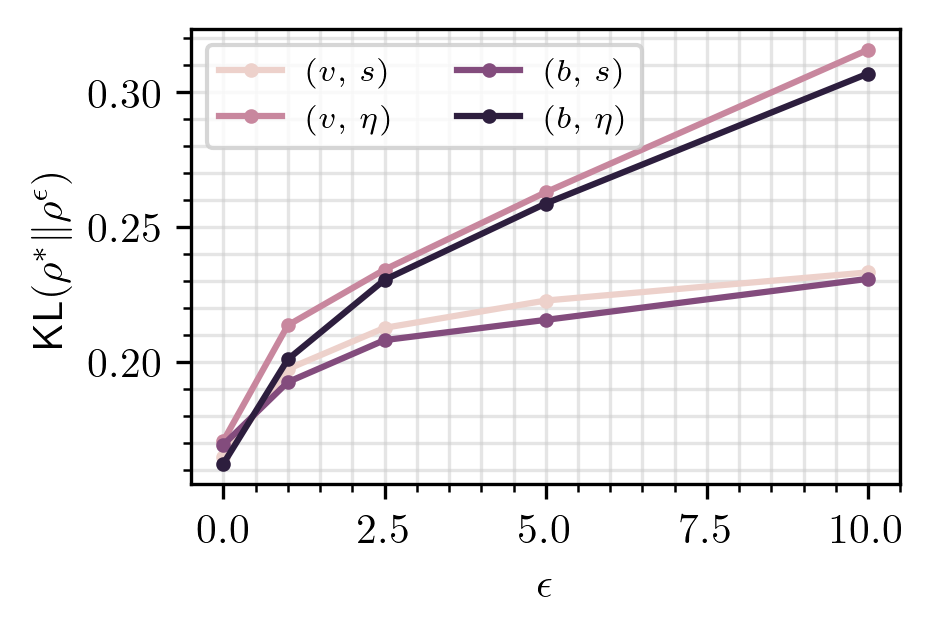

In [18]:
plt.close('all')
fig, ax = plt.subplots(figsize=(3, 2), constrained_layout=True)
cmap = sns.cubehelix_palette(n_colors=4)

for kk, key in enumerate(keys):
    bv_str   = r"$b$" if data[key]['config']['learn_b'] else r"$v$"
    seta_str = r"$\eta$" if data[key]['config']['learn_eta'] else r"$s$"
    label    = rf"({bv_str}, {seta_str})"
    ax.plot(np.array(eps_vals), np.array(kls[key]), label=label, color=cmap[kk], marker='o', ms=2.5)
    
# ideal_curve = lambda eps: b_loss/(2*eps) + s_loss*eps/2
# smooth_eps = np.linspace(eps_vals[0], eps_vals[-1], 100)
# ax.plot(smooth_eps, ideal_curve(smooth_eps), color='k', linestyle='--')
    
    
ax.legend(ncol=2, fontsize=7.5)
ax.set_xlabel(r"$\epsilon$")
ax.set_ylabel(r"$\mathsf{KL}(\rho^* \Vert \rho^\epsilon)$")
# fig.savefig('/scratch/nb3397/results/interpolant/gmm_exps/4_25_23/figs/online/kl_vs_eps.pdf', transparent=True, bbox_inches='tight', dpi=300)

print(b_loss, s_loss)

In [ ]:
dx*dy*np.sum(-np.log(kde_rslts['exact'])*kde_rslts['exact'])